In [1]:
# import libraries
import http.client
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Flatten, Dense, Dropout


# pull 5 years worth of amazon stock info directly from iex api
TOKEN = 'Tsk_c85274ff81f940e29ce16dbbffc7c4c8'

# use production data for final analysis
production_TOKEN = 'pk_6939d57e996d48b784f1b25bcd91f1f0'

# use sandbox for testing
url = 'sandbox.iexapis.com'

# use production for final analysis
production_url = 'cloud.iexapis'

# define http connection
conn = http.client.HTTPSConnection(url)

# make connection to api and get last 5 years stock price
conn.request("GET", "/stable/stock/AMZN/chart?token=" + TOKEN + "&range=5y")

# get response from web page
res = conn.getresponse()
print(res)

# read data in to variable
data = res.read()

# decode data to utf-8
print(data.decode("utf-8"))

[{"date":"2015-10-12","uClose":552.85,"uOpen":555.52,"uHigh":551.56,"uLow":559.6,"uVolume":2792080,"close":572.07,"open":549.44,"high":577.21,"low":552.6,"volume":2811280,"currency":"","change":0,"changePercent":0,"label":"Oct 12, 15","changeOverTime":0},{"date":"2015-10-13","uClose":575.5,"uOpen":562.81,"uHigh":563.1,"uLow":545.6,"uVolume":3033321,"close":554.9,"open":571.74,"high":557.3,"low":562.5,"volume":3012080,"currency":"","change":-1.32,"changePercent":-0.2439,"label":"Oct 13, 15","changeOverTime":-0.0024},{"date":"2015-10-14","uClose":568.09,"uOpen":559.83,"uHigh":558.29,"uLow":559.68,"uVolume":3620248,"close":556.1,"open":559.06,"high":575.54,"low":564.77,"volume":3607969,"currency":"","change":-4.25,"changePercent":-0.7716,"label":"Oct 14, 15","changeOverTime":-0.009912},{"date":"2015-10-15","uClose":586.72,"uOpen":570.9,"uHigh":565,"uLow":568,"uVolume":5097910,"close":585.09,"open":559.34,"high":587,"low":549,"volume":5144147,"currency":"","change":18.44,"changePercent":3.

In [2]:
# convert to json format
data = json.loads(data)

#print(data)
type(data)

list

In [3]:
# data is of type list - convert to pandas df
df = pd.DataFrame(data)

# sort values by date
df = df.sort_values('date')

# remove last date as this is what we will try to predict
df = df.iloc[:-1]


print(type(df))
print(df.head)
print(df.columns)



<class 'pandas.core.frame.DataFrame'>
<bound method NDFrame.head of             date   uClose    uOpen    uHigh     uLow  uVolume    close  \
0     2015-10-12   552.85   555.52   551.56   559.60  2792080   572.07   
1     2015-10-13   575.50   562.81   563.10   545.60  3033321   554.90   
2     2015-10-14   568.09   559.83   558.29   559.68  3620248   556.10   
3     2015-10-15   586.72   570.90   565.00   568.00  5097910   585.09   
4     2015-10-16   576.57   589.01   581.23   564.20  4471118   590.36   
...          ...      ...      ...      ...      ...      ...      ...   
1253  2020-10-02  3180.00  3159.57  3287.20  3125.00  5750002  3240.00   
1254  2020-10-05  3351.60  3154.67  3206.93  3186.67  3904218  3221.30   
1255  2020-10-06  3119.54  3255.00  3310.00  3222.00  5149940  3161.53   
1256  2020-10-07  3202.27  3284.00  3236.00  3159.15  4427444  3354.71   
1257  2020-10-08  3201.79  3374.12  3382.87  3240.97  3258397  3248.18   

         open     high      low   volume cu

In [4]:
# save df as csv file
df.to_csv('stock_dataset.csv')


In [5]:
# check for missing values
df.isna().any()

date              False
uClose            False
uOpen             False
uHigh             False
uLow              False
uVolume           False
close             False
open              False
high              False
low               False
volume            False
currency          False
change            False
changePercent     False
label             False
changeOverTime    False
dtype: bool

In [6]:
#plt.scatter(df['close'], df['volume'])

In [7]:
# check correlation between close price and volume
df['close'].corr(df['volume'])

0.13047887117158136

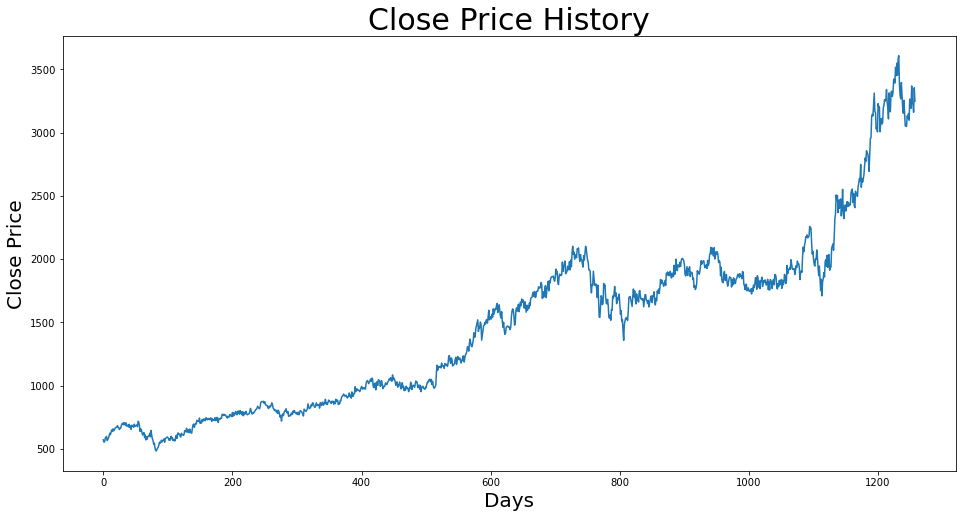

In [8]:
# set figure size to large
plt.figure(figsize=(16,8))

# set titles
plt.title('Close Price History', fontsize=30)

# plot close price
plt.plot(df['close'])
               
# set labels
plt.xlabel('Days', fontsize=20)
plt.ylabel('Close Price', fontsize=20)

plt.show()


In [9]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on - first 80% (last 20% used for validation)
training_data_len = int(np.ceil( len(dataset) * .8 ))


print(training_data_len)
print(dataset.shape)
print(len(dataset))

1007
(1258, 1)
1258


In [10]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

# use min/max scaler to scale data from 0 to 1
scaler = MinMaxScaler(feature_range=(0,1))
# fit the scaler to the data
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02828954],
       [0.02279484],
       [0.02317886],
       ...,
       [0.85696182],
       [0.91878278],
       [0.88469133]])

In [11]:
scaled_data.shape

(1258, 1)

In [12]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

print(train_data.shape)

# create empty lists
x_train = []
y_train = []

# loop through training data starting at day 60 since need to look 60 days back
for i in range(60, len(train_data)):
    #Split the data into x_train and y_train data sets
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into 3-dimensional array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)


(1007, 1)
(947, 60, 1)


In [13]:
# create the validation data
validation_data = scaled_data[int(training_data_len):, :]

print(validation_data.shape)

# create empty lists
x_valid = []
y_valid= []

# loop through training data starting at day 60 since need to look 60 days back
for i in range(60, len(validation_data)):
    #Split the data into x_train and y_train data sets
    x_valid.append(validation_data[i-60:i, 0])
    y_valid.append(validation_data[i, 0])

        
# Convert the x_train and y_train to numpy arrays 
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

#Reshape the data into 3-dimensional array
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))


x_valid.shape

(251, 1)


(191, 60, 1)

In [14]:
#Build the LSTM model

# set model type to sequential
model = Sequential()
# add input layer
model.add(LSTM(units = 100, return_sequences=True, input_shape= (x_train.shape[1], 1)))
# add 1st layers
model.add(LSTM(units = 100, return_sequences=True))
model.add(Dropout(rate = 0.2))
# add 2nd layers
model.add(LSTM(units = 100, return_sequences=True))
model.add(Dropout(rate = 0.2))
# add 3rd layers
model.add(LSTM(units = 100, return_sequences= False))
model.add(Dropout(rate = 0.2))
# add output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# metrics=['acc']

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 100)           80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0

In [15]:
#fit the model with bacth size of 20 for 100 epochs
history = model.fit(x_train,
          y_train, 
          batch_size=20, 
          epochs=100, 
          validation_data = [x_valid, y_valid])

Train on 947 samples, validate on 191 samples
Epoch 1/100
947/947 [==============================] - 19s 20ms/sample - loss: 0.0079 - val_loss: 0.0161
Epoch 2/100
947/947 [==============================] - 9s 9ms/sample - loss: 0.0013 - val_loss: 0.0085
Epoch 3/100
947/947 [==============================] - 9s 9ms/sample - loss: 0.0012 - val_loss: 0.0087
Epoch 4/100
947/947 [==============================] - 9s 10ms/sample - loss: 0.0012 - val_loss: 0.0088
Epoch 5/100
947/947 [==============================] - 9s 9ms/sample - loss: 0.0010 - val_loss: 0.0111
Epoch 6/100
947/947 [==============================] - 9s 9ms/sample - loss: 0.0010 - val_loss: 0.0119
Epoch 7/100
947/947 [==============================] - 10s 10ms/sample - loss: 9.8858e-04 - val_loss: 0.0079
Epoch 8/100
947/947 [==============================] - 9s 10ms/sample - loss: 9.1776e-04 - val_loss: 0.0183
Epoch 9/100
947/947 [==============================] - 9s 10ms/sample - loss: 0.0011 - val_loss: 0.0213
Epoch 10/100

947/947 [==============================] - 9s 10ms/sample - loss: 4.1030e-04 - val_loss: 0.0024
Epoch 77/100
947/947 [==============================] - 9s 10ms/sample - loss: 3.7541e-04 - val_loss: 0.0027
Epoch 78/100
947/947 [==============================] - 9s 9ms/sample - loss: 3.4219e-04 - val_loss: 0.0030
Epoch 79/100
947/947 [==============================] - 9s 9ms/sample - loss: 3.4780e-04 - val_loss: 0.0023
Epoch 80/100
947/947 [==============================] - 10s 11ms/sample - loss: 3.9504e-04 - val_loss: 0.0039
Epoch 81/100
947/947 [==============================] - 9s 10ms/sample - loss: 4.0089e-04 - val_loss: 0.0026
Epoch 82/100
947/947 [==============================] - 10s 10ms/sample - loss: 2.9984e-04 - val_loss: 0.0038
Epoch 83/100
947/947 [==============================] - 9s 9ms/sample - loss: 3.2899e-04 - val_loss: 0.0011
Epoch 84/100
947/947 [==============================] - 9s 9ms/sample - loss: 3.3392e-04 - val_loss: 0.0027
Epoch 85/100
947/947 [============

In [16]:
#Create the testing data set
#Create a new array containing scaled values for test data
test_data = scaled_data[training_data_len - 60: , : ]

#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len : , : ]

# loop through test dataset starting 60 days out
for i in range(60, len(test_data)) :
    x_test.append(test_data[i-60 : i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)
print(x_test.shape)

# Reshape the x_test data (rows = number of samples, columns = time steps, features = 1 ('close' price))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# confirm shape of array
print(x_test.shape)

# Get the models predicted price values 
predictions = model.predict(x_test)
print(predictions.shape)

# reverse the scaling done on the predictions to get actual price
predictions = scaler.inverse_transform(predictions)


(251, 60)
(251, 60, 1)
(251, 1)


In [17]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

45.9151393449639

C:\Users\Tim\anaconda3\envs\minimal\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


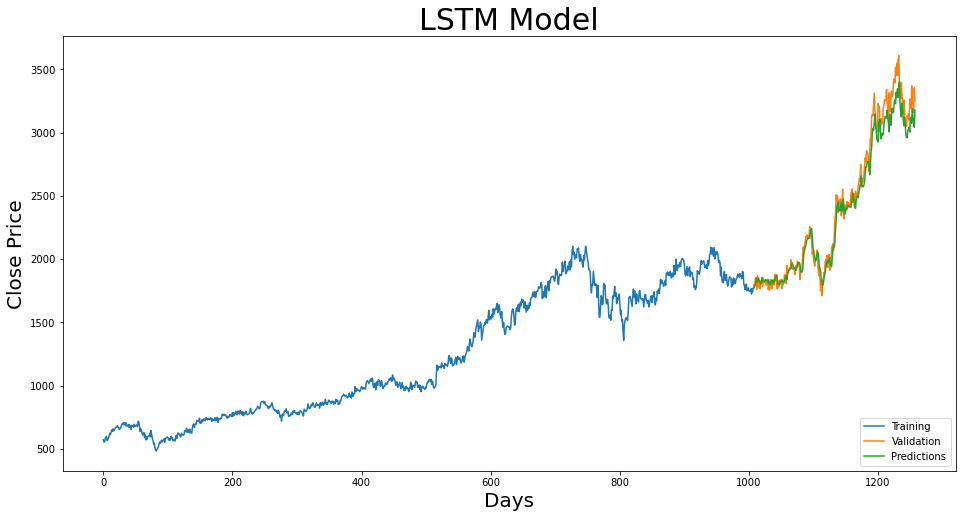

In [18]:
# Plot the data

# define training and validation sets for plotting
train = data[:training_data_len]
valid = data[training_data_len:]

# define predictions for validation set
valid['predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))

# set title and labels
plt.title('LSTM Model', fontsize=30)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Close Price', fontsize=20)

# plot training data, validation data and predictions
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['Training', 'Validation', 'Predictions'], loc='lower right')
plt.show()

C:\Users\Tim\anaconda3\envs\minimal\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


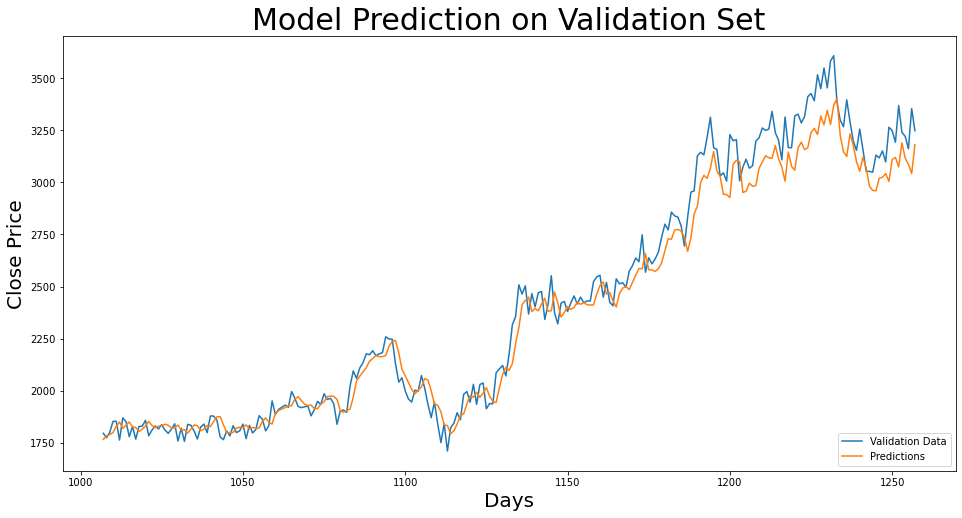

In [19]:
# Plot the data

# define training and validation sets for plotting
valid = data[training_data_len:]
valid['predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))

# set title and labels
plt.title('Model Prediction on Validation Set', fontsize=30)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Close Price', fontsize=20)

# plot training data, validation data and predictions     
plt.plot(valid[['close', 'predictions']])
plt.legend(['Validation Data', 'Predictions'], loc='lower right')
plt.show()

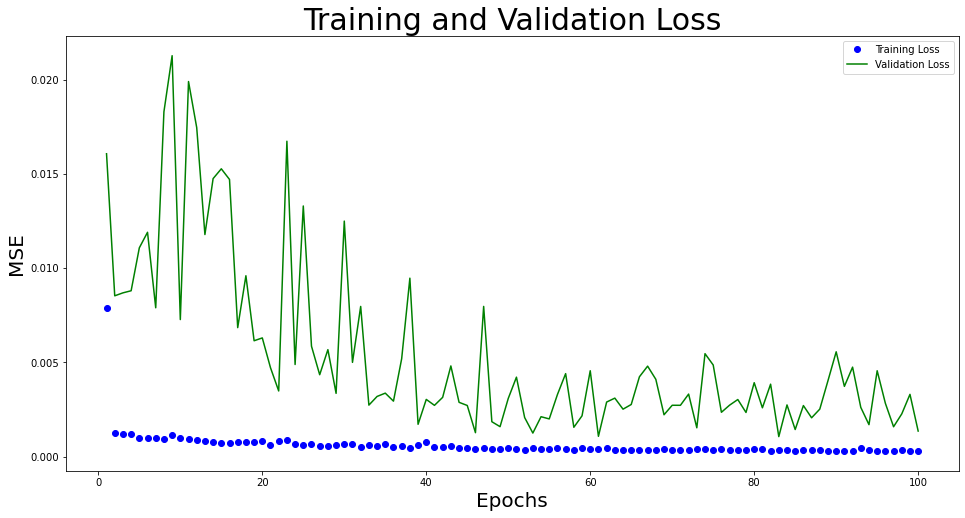

In [20]:
# pull validation and loss info from model history
loss = history.history['loss']
val_loss = history.history['val_loss']

# number of epochs
epochs = range(1, len(loss) + 1)

# increase figure size
plt.figure(figsize=(16,8))

# plto epochs against training abd validaiton losses
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')

# set labels, titles, and legend
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.title('Training and Validation Loss', fontsize=30)
plt.legend()

plt.show()

In [21]:
np.where(val_loss == min(val_loss))

(array([82], dtype=int64),)

In [22]:
#Show the valid and predicted prices
valid

,close,predictions
1007,1795.30,1765.953369
1008,1774.12,1783.299438
1009,1800.40,1789.018188
1010,1852.54,1799.303589
1011,1853.07,1828.752441
...,...,...
1253,3240.00,3190.264160
1254,3221.30,3117.148193
1255,3161.53,3087.062256
1256,3354.71,3042.598389


In [23]:
# create new dataframe to hold test data
new_df = data.filter(['close'])

# look at values from days ago
last_60_days = new_df[-60:].values

# scale data between 0 1nd 1
last_60_days_scaled = scaler.transform(last_60_days)

# initialize empty list to store test data
X_test = []

# append scaled data to list
X_test.append(last_60_days_scaled)

# convert to numpy array
X_test = np.array(X_test)

# reshape numpy array into 3 dimension for model prediction
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# predict price on test data
pred_price = model.predict(X_test)

# reverse scaling down on price (0-1) to actual price
pred_price = scaler.inverse_transform(pred_price)

# predict next day price
print(pred_price)


[[3134.5469]]


In [24]:
# data is of type list - convert to pandas df
final = pd.DataFrame(new_df)

# set final to last date (date we are predicting)
final = final.iloc[-1]

print('Predicted Price: ', pred_price)
print('Actual Price: ', final['close'])


Predicted Price:  [[3134.5469]]
Actual Price:  3248.18
